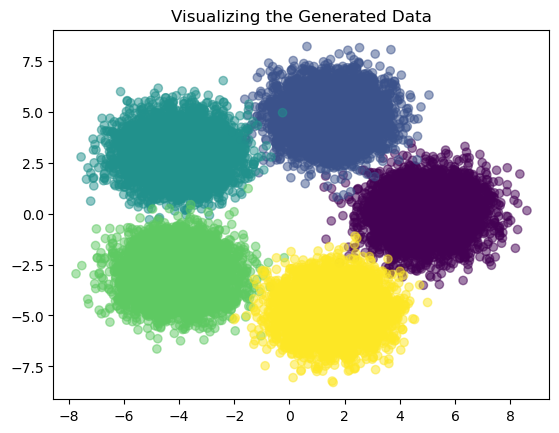

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score
from sklearn.random_projection import GaussianRandomProjection
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


def generate_data(n_samples=300, d=5, concentration_param=1):
    angles = np.linspace(0, 2 * np.pi, 6)[:-1]  
    centers = np.vstack([d * np.cos(angles), d * np.sin(angles)]).T

    samples = []
    for center in centers:
        mean = center
        cov = np.eye(2) / concentration_param 
        gaussian_samples = np.random.multivariate_normal(mean, cov, n_samples)
        samples.append(gaussian_samples)

    data = np.vstack(samples)
    labels = np.repeat(np.arange(len(centers)), n_samples)  

    return data, np.array(labels)

data, labels = generate_data(n_samples=5000, d=5, concentration_param=1)
plt.scatter(data[:,0], data[:,1], c=labels, alpha=0.5, cmap='viridis')
plt.title("Visualizing the Generated Data")
plt.show()


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (2 < 50).The dimensionality of the problem will not be reduced.
  warnings.warn(


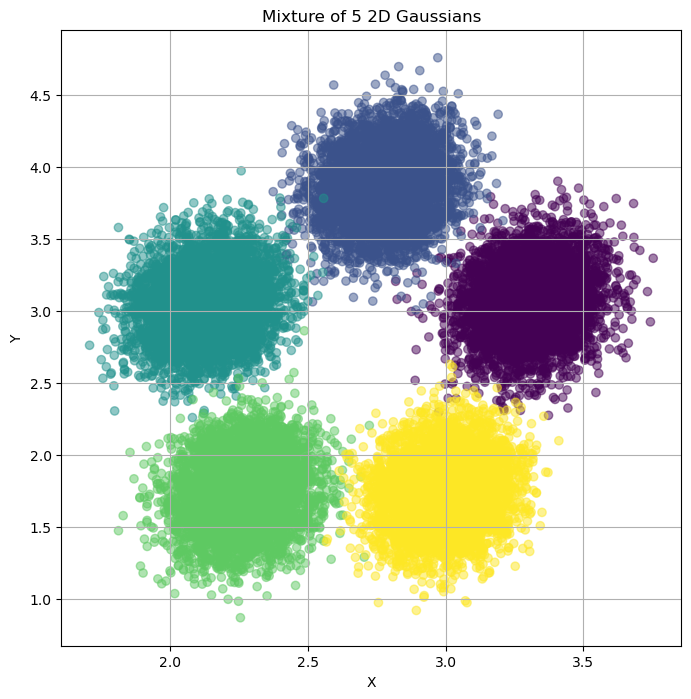

In [196]:
def project_and_normalize(data, n_components=50):
    transformer = GaussianRandomProjection(n_components=n_components)
    data_projected = transformer.fit_transform(data)
    min_val = np.min(data_projected)
    if min_val < 0:
        data_projected -= min_val
    return data_projected

data_embedded = project_and_normalize(data, 50)

plt.figure(figsize=(8, 8))
plt.scatter(data_embedded[:, 0], data_embedded[:, 1], c=labels, alpha=0.5, cmap='viridis')
plt.title('Mixture of 5 2D Gaussians')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

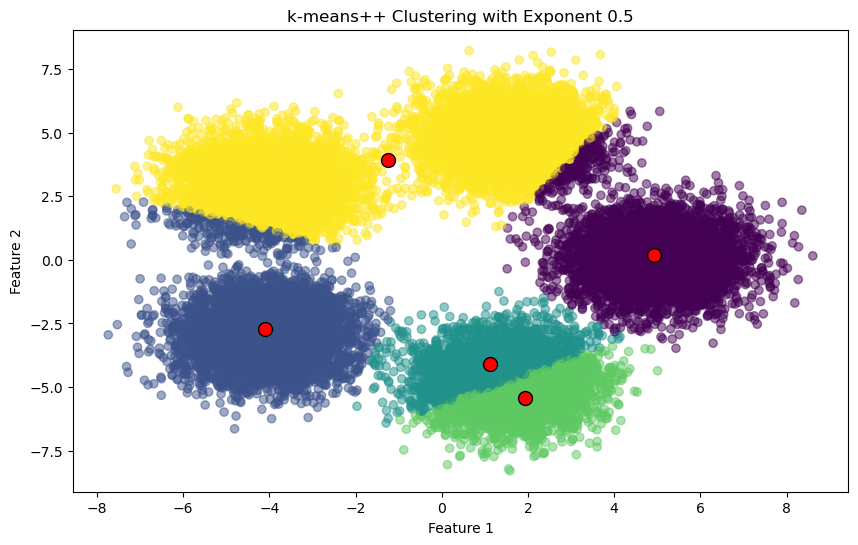

0.5-clusters k-means++: Inertia = 130290.88024788703, Silhouette Score = 0.45581007940098445


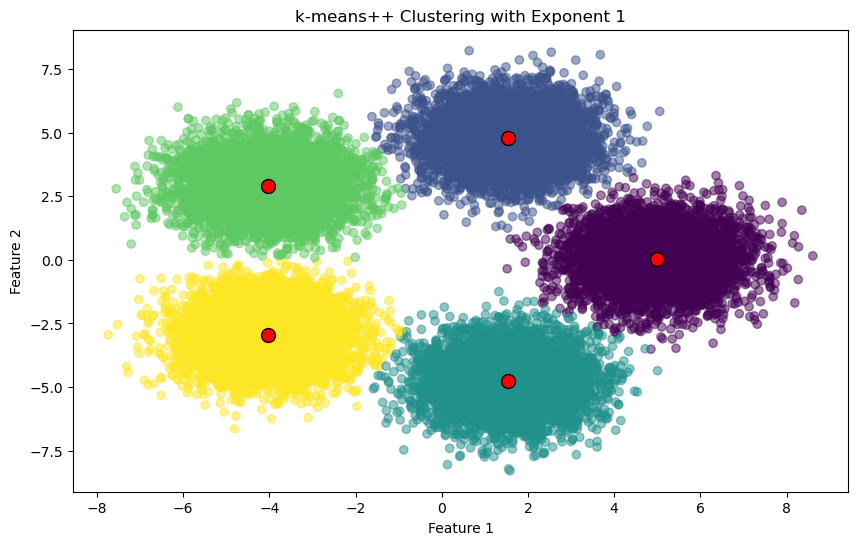

1-clusters k-means++: Inertia = 49305.86238387222, Silhouette Score = 0.5596819110107136


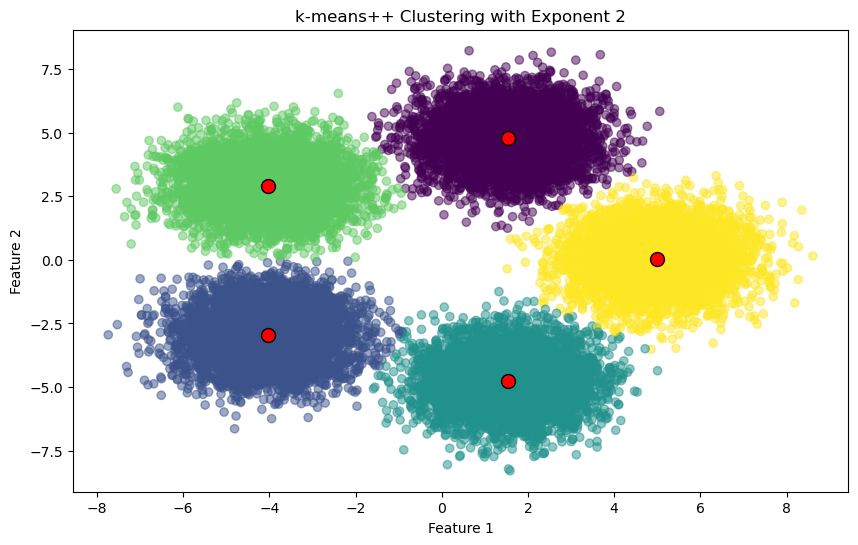

2-clusters k-means++: Inertia = 49305.86238387222, Silhouette Score = 0.5943058548806234


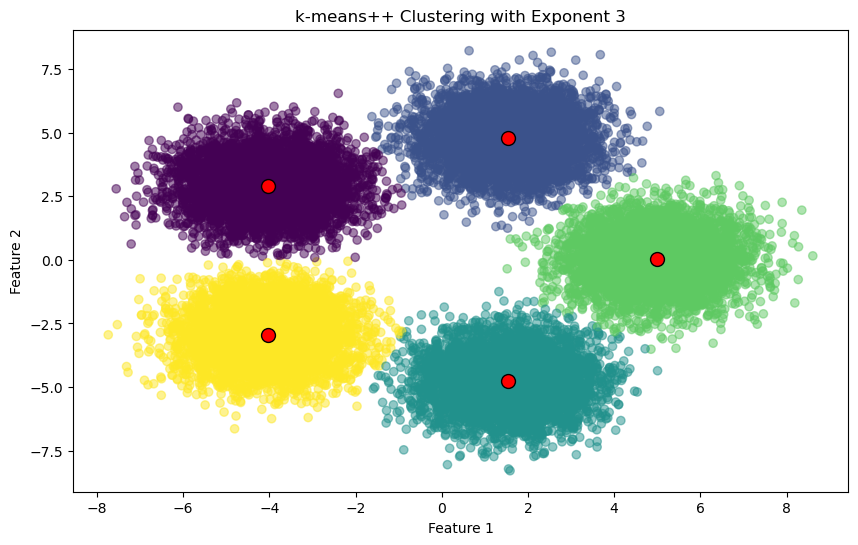

3-clusters k-means++: Inertia = 49305.86238387222, Silhouette Score = 0.6116178268155782


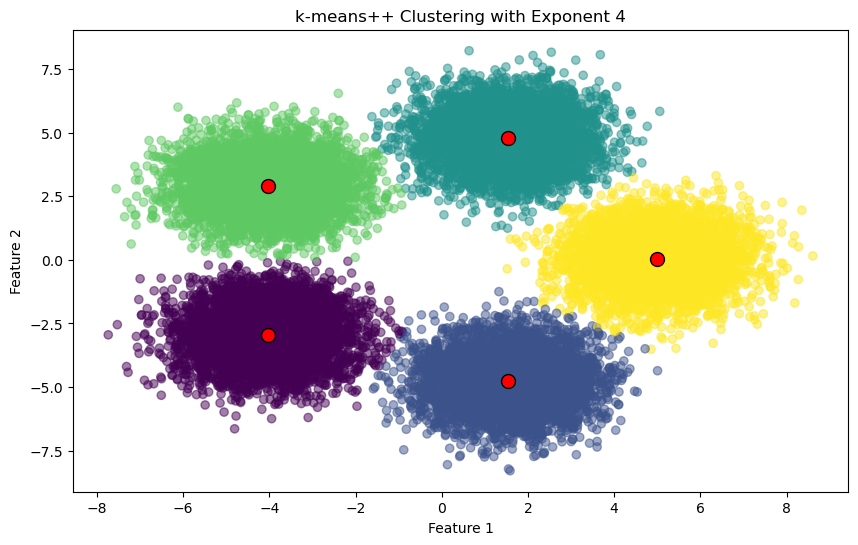

4-clusters k-means++: Inertia = 49305.86238387222, Silhouette Score = 0.6220050099765511


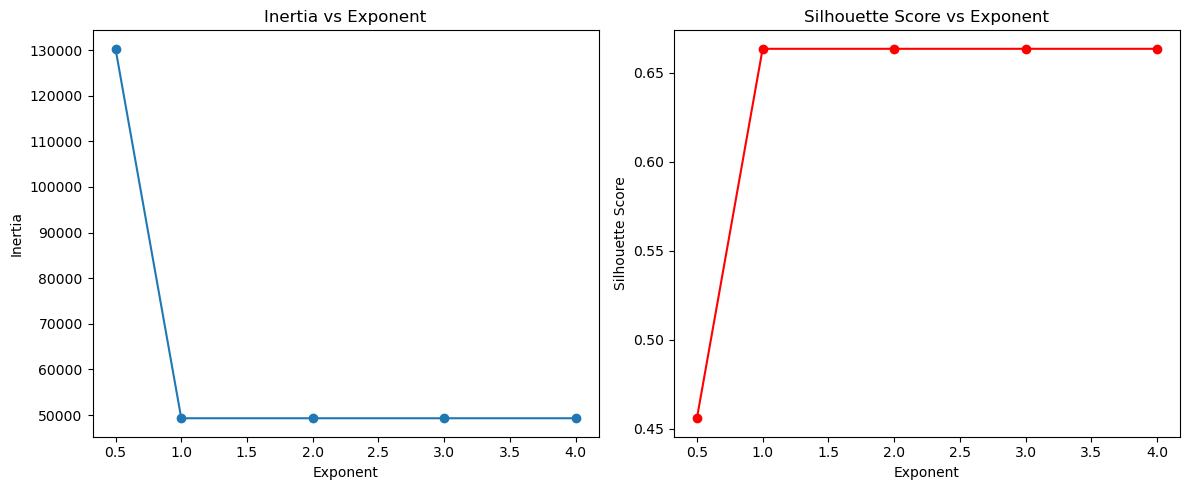

In [197]:
def run_kmeans_plusplus(data, n_clusters=5, exponent=2):
    initial_centers = np.zeros((n_clusters, data.shape[1]))
    random_idx = np.random.randint(len(data))
    initial_centers[0] = data[random_idx]

    for i in range(1, n_clusters):
        distances = np.array([min([np.linalg.norm(x-c)**exponent for c in initial_centers[:i]]) for x in data])
        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        random_probability = np.random.rand()
        next_center_idx = np.where(cumulative_probabilities >= random_probability)[0][0]
        initial_centers[i] = data[next_center_idx]

    kmeans = KMeans(n_clusters=n_clusters, init=initial_centers, n_init=1)
    kmeans.fit(data)
    return kmeans.inertia_, silhouette_score(data, kmeans.labels_), kmeans.cluster_centers_, kmeans.labels_

exponents = [0.5, 1, 2, 3, 4]
inertias = []
silhouette_scores = []

for exponent in exponents:
    inertia, silhouette, centers, labels = run_kmeans_plusplus(data, exponent=exponent)
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    mean_silhouette_score = np.mean(silhouette_scores)

    plt.figure(figsize=(10, 6))
    plt.scatter(data[:,0], data[:,1], c=labels, alpha=0.5, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='red', s=100, edgecolor='black')
    plt.title(f"k-means++ Clustering with Exponent {exponent}")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    print(f"{exponent}-clusters k-means++: Inertia = {inertia}, Silhouette Score = {mean_silhouette_score}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(exponents, inertias, marker='o')
plt.xlabel('Exponent')
plt.ylabel('Inertia')
plt.title('Inertia vs Exponent')

plt.subplot(1, 2, 2)
plt.plot(exponents, silhouette_scores, marker='o', color='red')
plt.xlabel('Exponent')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Exponent')

plt.tight_layout()
plt.show()

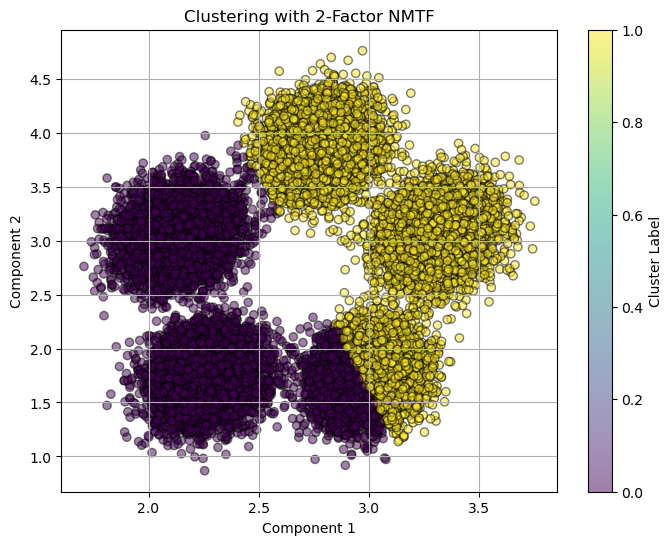

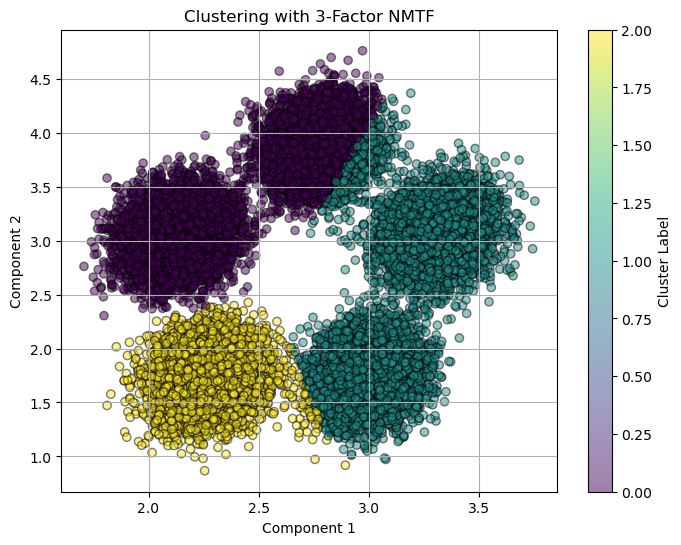

2-factor NMF: Reconstruction Error = 475.31980109969436, Silhouette Score = 0.41388388941069437
3-factor NMF: Reconstruction Error = 42.51191498571243, Silhouette Score = 0.4542936067336982


In [198]:
def run_nmtf(data, rank=2):
    model = NMF(n_components=rank, init='random', random_state=42, max_iter=1000)
    W = model.fit_transform(data)
    H = model.components_
    reconstruction_error = model.reconstruction_err_
    labels = np.argmax(W, axis=1)
    silhouette_nmf = silhouette_score(data, labels)
    return W, H, labels, reconstruction_error, silhouette_nmf

W2, H2, labels2, reconstruction_error2, silhouette_nmf2 = run_nmtf(data_embedded, rank=2)
W3, H3, labels3, reconstruction_error3, silhouette_nmf3 = run_nmtf(data_embedded, rank=3)

def plot_clusters(data, labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.5, edgecolors='k')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(label='Cluster Label')
    plt.grid(True)
    plt.show()

plot_clusters(data_embedded, labels2, "Clustering with 2-Factor NMTF")
plot_clusters(data_embedded, labels3, "Clustering with 3-Factor NMTF")
print(f"{2}-factor NMF: Reconstruction Error = {reconstruction_error2}, Silhouette Score = {silhouette_nmf2}")
print(f"{3}-factor NMF: Reconstruction Error = {reconstruction_error3}, Silhouette Score = {silhouette_nmf3}")

In [199]:
file_path = "penguins.csv"
penguins_data = pd.read_csv(file_path)

numeric_features = penguins_data.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = penguins_data.select_dtypes(include=[object]).columns.tolist()  # Automatically select categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

data_processed = preprocessor.fit_transform(penguins_data)
data_processed_embedded = project_and_normalize(data_processed)

c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (8 < 50).The dimensionality of the problem will not be reduced.
  warnings.warn(


K-means++ 2 Clusters: Inertia=1013.9268815536536, Silhouette=0.4291819002414392


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K-means++ 3 Clusters: Inertia=667.2161492117209, Silhouette=0.42994578138675044
K-means++ 4 Clusters: Inertia=493.6985165040432, Silhouette=0.3797353797819603
K-means++ 5 Clusters: Inertia=703.9687930503435, Silhouette=0.3306477208556292

c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(



K-means++ 6 Clusters: Inertia=281.36644458895404, Silhouette=0.44104371646528384


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K-means++ 7 Clusters: Inertia=189.54082693240855, Silhouette=0.5035671499700811
K-means++ 8 Clusters: Inertia=178.06414462306725, Silhouette=0.4501354664379033


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K-means++ 9 Clusters: Inertia=170.11985479110052, Silhouette=0.40421731177391473
K-means++ 10 Clusters: Inertia=160.90693783737976, Silhouette=0.39075482018866226
NMTF 2 Components: Reconstruction Error=27.288220145842512, Silhouette=0.31024390166708826


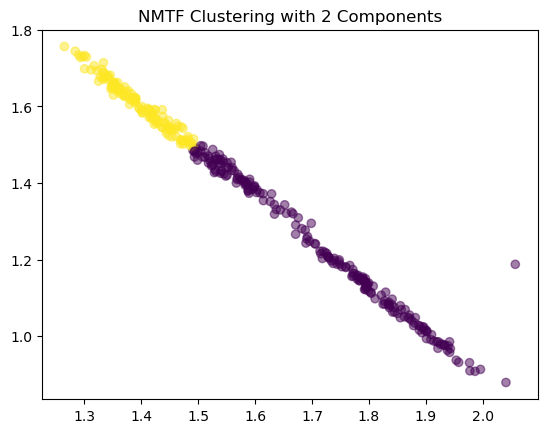

NMTF 3 Components: Reconstruction Error=20.024010506488455, Silhouette=0.25502093501785134


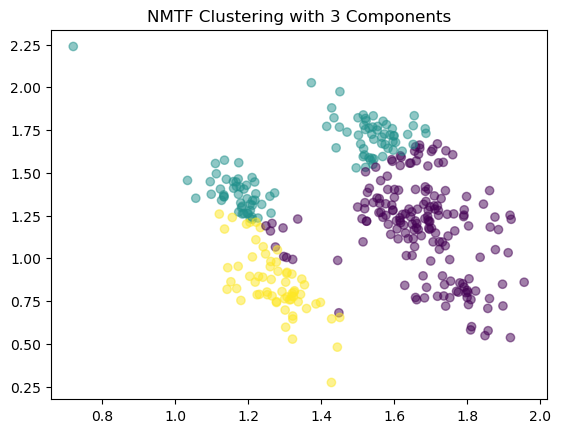

In [200]:
range_values = range(2, 11)  # Exploring from 2 to 10 clusters/components

inertias = []
silhouette_scores_kmeans = []
silhouette_scores_nmtf = []
reconstruction_errors = []

for k in range_values:
    inertia, silhouette_k, centers_k, labels_k = run_kmeans_plusplus(data_processed, n_clusters=k)
    print(f"K-means++ {k} Clusters: Inertia={inertia}, Silhouette={silhouette_k}")


W2, H2, labels_n2, error2, silhouette_n2 = run_nmtf(data_processed_embedded, rank=2)
print(f"NMTF 2 Components: Reconstruction Error={error2}, Silhouette={silhouette_n2}")

plt.scatter(W2[:, 0], W2[:, 1], c=labels_n2, cmap='viridis', alpha=0.5)
plt.title("NMTF Clustering with 2 Components")
plt.show()

W3, H3, labels_n3, error3, silhouette_n3 = run_nmtf(data_processed_embedded, rank=3)    
print(f"NMTF 3 Components: Reconstruction Error={error3}, Silhouette={silhouette_n3}")

plt.scatter(W3[:, 0], W3[:, 1], c=labels_n3, cmap='viridis', alpha=0.5)
plt.title("NMTF Clustering with 3 Components")
plt.show()


In [201]:
file_path = "wine-clustering.csv"
wine_data = pd.read_csv(file_path)

numeric_features = wine_data.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = wine_data.select_dtypes(include=[object]).columns.tolist()  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

data_processed = preprocessor.fit_transform(wine_data)
data_processed_embedded = project_and_normalize(data_processed)

c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\random_projection.py:408: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (13 < 50).The dimensionality of the problem will not be reduced.
  warnings.warn(


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-means++ 2 Clusters: Inertia=1659.0079672511504, Silhouette=0.26831340971052126
K-means++ 3 Clusters: Inertia=1282.4635183465311, Silhouette=0.2806817957373884
K-means++ 4 Clusters: Inertia=1214.0013472377702, Silhouette=0.21728198043995398


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-means++ 5 Clusters: Inertia=1120.7292337868448, Silhouette=0.21167203705241489
K-means++ 6 Clusters: Inertia=1063.4854116790532, Silhouette=0.17397223137101173
K-means++ 7 Clusters: Inertia=1008.5213362056725, Silhouette=0.20095633340877062


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-means++ 8 Clusters: Inertia=976.309575668451, Silhouette=0.19043692723278074
K-means++ 9 Clusters: Inertia=946.8868740344701, Silhouette=0.18787390777692234


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


K-means++ 10 Clusters: Inertia=930.2759746826733, Silhouette=0.11432021701182093
NMTF 2 Components: Reconstruction Error=38.397380505726495, Silhouette=0.28178054834804356


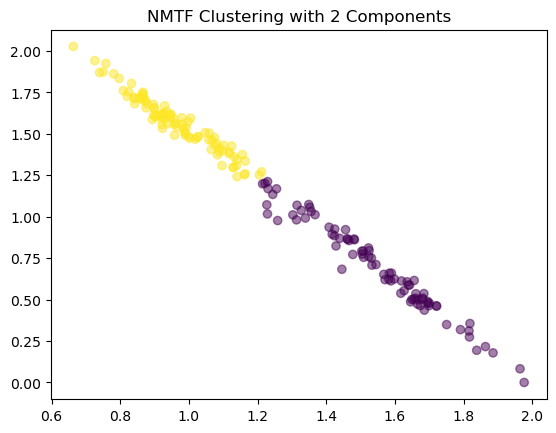

NMTF 3 Components: Reconstruction Error=32.40621349202418, Silhouette=0.287530507221172


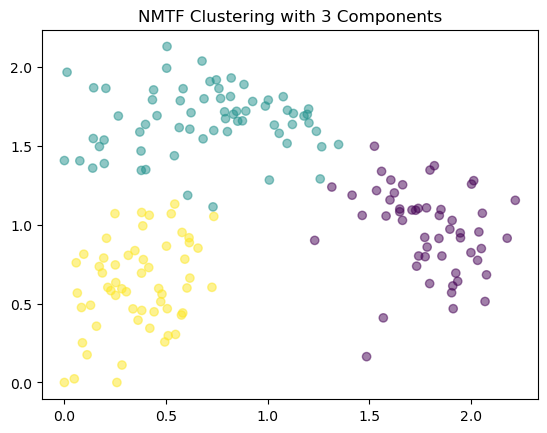

In [202]:
range_values = range(2, 11)  

inertias = []
silhouette_scores_kmeans = []
silhouette_scores_nmtf = []
reconstruction_errors = []

for k in range_values:
    inertia, silhouette_k, centers_k, labels_k = run_kmeans_plusplus(data_processed, n_clusters=k)
    print(f"K-means++ {k} Clusters: Inertia={inertia}, Silhouette={silhouette_k}")
    

W2, H2, labels_n2, error2, silhouette_n2 = run_nmtf(data_processed_embedded, rank=2)
print(f"NMTF 2 Components: Reconstruction Error={error2}, Silhouette={silhouette_n2}")

plt.scatter(W2[:, 0], W2[:, 1], c=labels_n2, cmap='viridis', alpha=0.5)
plt.title("NMTF Clustering with 2 Components")
plt.show()

W3, H3, labels_n3, error3, silhouette_n3 = run_nmtf(data_processed_embedded, rank=3)    
print(f"NMTF 3 Components: Reconstruction Error={error3}, Silhouette={silhouette_n3}")

plt.scatter(W3[:, 0], W3[:, 1], c=labels_n3, cmap='viridis', alpha=0.5)
plt.title("NMTF Clustering with 3 Components")
plt.show()

In [203]:
file_path = "Country-data.csv"
contry_data = pd.read_csv(file_path)

numeric_features = contry_data.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = contry_data.select_dtypes(include=[object]).columns.tolist()  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

data_processed = preprocessor.fit_transform(contry_data)
data_processed_embedded = project_and_normalize(data_processed)

In [204]:
def run_kmeans_plusplus(data, n_clusters=5, exponent=2):
    initial_centers = np.zeros((n_clusters, data.shape[1]))
    random_idx = np.random.randint(data.shape[0])
    initial_centers[0] = data[random_idx].toarray()  # Convert csr_matrix to array
    
    for i in range(1, n_clusters):
        distances = np.array([min([np.linalg.norm(x-c)**exponent for c in initial_centers[:i]]) for x in data])
        
        # Find the next center based on distances
        next_center_idx = np.argmax(distances)
        initial_centers[i] = data[next_center_idx].toarray()  
    
    # Run K-means with initial centers
    kmeans = KMeans(n_clusters=n_clusters, init=initial_centers, n_init=1)
    kmeans.fit(data)
    
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    silhouette = silhouette_score(data, labels)
    
    return inertia, silhouette, kmeans.cluster_centers_, labels


K-means++ 2 Clusters: Inertia=1570.942754028697, Silhouette=0.6036768768747486
K-means++ 3 Clusters: Inertia=1142.4334752362768, Silhouette=0.23326804654804048
K-means++ 4 Clusters: Inertia=974.9844668252281, Silhouette=0.25792073281067446
K-means++ 5 Clusters: Inertia=782.1250567873996, Silhouette=0.2542046583651841
K-means++ 6 Clusters: Inertia=725.4618045486017, Silhouette=0.24854998993170052
K-means++ 7 Clusters: Inertia=684.0784932980164, Silhouette=0.21924825473961632
K-means++ 8 Clusters: Inertia=636.9497986384501, Silhouette=0.1931555088047827
K-means++ 9 Clusters: Inertia=629.9569714678381, Silhouette=0.15777296290947274
K-means++ 10 Clusters: Inertia=586.0759383533042, Silhouette=0.17096852767349893
NMTF 2 Components: Reconstruction Error=30.660920918437455, Silhouette=0.2746144475768756


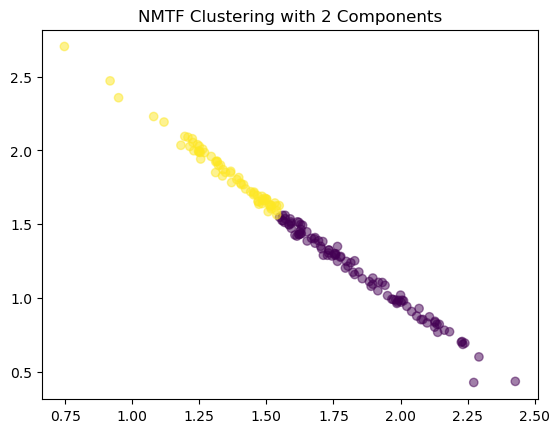

NMTF 3 Components: Reconstruction Error=24.693734161105848, Silhouette=0.23518037629794541


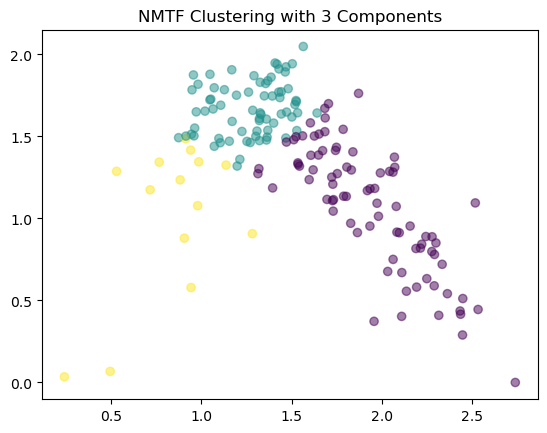

In [205]:
range_values = range(2, 11) 

inertias = []
silhouette_scores_kmeans = []
silhouette_scores_nmtf = []
reconstruction_errors = []

for k in range_values:
    inertia, silhouette_k, centers_k, labels_k = run_kmeans_plusplus(data_processed, n_clusters=k)
    print(f"K-means++ {k} Clusters: Inertia={inertia}, Silhouette={silhouette_k}")
    

W2, H2, labels_n2, error2, silhouette_n2 = run_nmtf(data_processed_embedded, rank=2)
print(f"NMTF 2 Components: Reconstruction Error={error2}, Silhouette={silhouette_n2}")

plt.scatter(W2[:, 0], W2[:, 1], c=labels_n2, cmap='viridis', alpha=0.5)
plt.title("NMTF Clustering with 2 Components")
plt.show()

W3, H3, labels_n3, error3, silhouette_n3 = run_nmtf(data_processed_embedded, rank=3)    
print(f"NMTF 3 Components: Reconstruction Error={error3}, Silhouette={silhouette_n3}")

plt.scatter(W3[:, 0], W3[:, 1], c=labels_n3, cmap='viridis', alpha=0.5)
plt.title("NMTF Clustering with 3 Components")
plt.show()